# Train a DC GAN

In [19]:
import torch  # Import PyTorch library
import torch.nn as nn  # Import neural network module
import torch.optim as optim  # Import optimization module
from torchvision import datasets, transforms  # Import datasets and transforms
from torchvision.utils import save_image, make_grid  # Import utility to save images
import torchvision  # Import torchvision library
import matplotlib.pyplot as plt  # Import plotting library
import os  # Import os module for file operations
import numpy as np  # Import numpy library

In [20]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device
print(f"Using device: {device}")  # Print the device being used

Using device: cuda


In [21]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize each RGB channel to [-1, 1]
])  # Compose transformations

In [22]:
# Load the dataset from local machine
data_dir = r'D:\Users\VICTOR\Desktop\ADRL\Assignment 1\Animal_data_resized\animals'  # data_dir is a string that stores the path to the directory containing the images
dataset = datasets.ImageFolder(root=data_dir, transform=transform)  # dataset is an object of the ImageFolder class, which is used to load images from a folder
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)  # dataloader is an object of the DataLoader class, which is used to load data in batches
print(f"Loaded {len(dataset)} images.")  # Print number of images loaded

Loaded 5400 images.


In [ ]:
# Load the dataset from Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your dataset in Google Drive
data_dir = '/content/drive/MyDrive/path/to/your/Animal_data_resized/animals'

# Print the data directory to verify
print(f"Data directory: {data_dir}")

# Check if the directory exists
import os
if os.path.exists(data_dir):
    print(f"Directory exists. Found {len(os.listdir(data_dir))} items.")
else:
    print("Directory not found. Please check the path.")

# Update the dataset and dataloader with the new path
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
print(f"Loaded {len(dataset)} images.")


In [23]:
# Define the Generator model class
class Generator(nn.Module):  # Defined a class named Generator that inherits from nn.Module of PyTorch. nn.module is a class that defines a neural network in PyTorch
    def __init__(self):  # Constructor function. Whenever an instance of the class is created, this function initializes the instance
        super(Generator, self).__init__()  # Call parent constructor before any Generator specific initialization.
                                           # This pattern ensures that all the benefits and functionalities provided by nn.Module are available to Generator, like parameter tracking, module moving to different devices (CPU/GPU), etc.
        self.main = nn.Sequential( # We define property of class called main, which is a ordered  ordered sequence of neural network layers.
                                   # When we pass input through self.main, it goes through these layers in the order they are listed.
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),  # Input: N x 100 x 1 x 1, Output: N x 512 x 4 x 4, 512 filters of size 4x4x100
            nn.BatchNorm2d(num_features=512),  # Batch normalization for 512 channels
            nn.ReLU(inplace=True),  # ReLU activation
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 512 x 4 x 4, Output: N x 256 x 8 x 8, 256 filters of size 4x4x512
            nn.BatchNorm2d(num_features=256),  # Batch normalization for 256 channels
            nn.ReLU(inplace=True),  # ReLU activation
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 256 x 8 x 8, Output: N x 128 x 16 x 16, 128 filters of size 4x4x256
            nn.BatchNorm2d(num_features=128),  # Batch normalization for 128 channels
            nn.ReLU(inplace=True),  # ReLU activation
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 128 x 16 x 16, Output: N x 64 x 32 x 32, 64 filters of size 4x4x128
            nn.BatchNorm2d(num_features=64),  # Batch normalization for 64 channels
            nn.ReLU(inplace=True),  # ReLU activation
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 64 x 32 x 32, Output: N x 32 x 64 x 64, 32 filters of size 4x4x64
            nn.BatchNorm2d(num_features=32),  # Batch normalization for 32 channels
            nn.ReLU(inplace=True),  # ReLU activation
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 32 x 64 x 64, Output: N x 3 x 128 x 128, 3 filters of size 4x4x32
            nn.Tanh()  # Tanh activation to ensure output is in range [-1, 1]
        )
        self.initialize_weights()


    def forward(self, input):  # Forward pass
        return self.main(input)  # Return the output directly, which is in [-1, 1] range
    
    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(module.weight.data, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.constant_(module.bias.data, 0.0)

In [24]:
def sample_noise(batch_size, latent_dim=100):
    noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Generate noise with correct shape
    print(f"Debug - Noise shape: {noise.shape}")  # Debug: Print shape of noise
    print(f"Debug - Noise mean: {noise.mean():.4f}, std: {noise.std():.4f}")  # Debug: Print statistics of noise
    return noise  # Return the noise tensor

In [25]:
# Define the Discriminator model
class Discriminator(nn.Module):  # Discriminator class
    def __init__(self):  # Constructor
        super(Discriminator, self).__init__()  # Call parent constructor
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 3 x 128 x 128, Output: N x 64 x 64 x 64, 64 filters of size 4x4x3
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation with negative slope of 0.2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 64 x 64 x 64, Output: N x 128 x 32 x 32, 128 filters of size 4x4x64
            nn.BatchNorm2d(num_features=128),  # Batch normalization for 128 channels
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation with negative slope of 0.2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 128 x 32 x 32, Output: N x 256 x 16 x 16, 256 filters of size 4x4x128
            nn.BatchNorm2d(num_features=256),  # Batch normalization for 256 channels
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation with negative slope of 0.2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),  # Input: N x 256 x 16 x 16, Output: N x 512 x 8 x 8, 512 filters of size 4x4x256
            nn.BatchNorm2d(num_features=512),  # Batch normalization for 512 channels
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation with negative slope of 0.2
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),  # Input: N x 512 x 8 x 8, Output: N x 256 x 8 x 8, 256 filters of size 3x3x512
            nn.BatchNorm2d(256),  # Batch normalization for 256 channels
            nn.LeakyReLU(0.2, inplace=True),  # Activation with negative slope of 0.2
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),  # Input: N x 256 x 8 x 8, Output: N x 128 x 4 x 4, 128 filters of size 3x3x256
            nn.BatchNorm2d(128),  # Batch normalization for 128 channels
            nn.LeakyReLU(0.2, inplace=True),  # Activation with negative slope of 0.2
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),  # Input: N x 128 x 4 x 4, Output: N x 1 x 1 x 1, 1 filter of size 4x4x128
            nn.Flatten(),  # Flatten the output to N x 1
            nn.Sigmoid()  # Sigmoid activation to output probabilities in range [0, 1]         
        )  # Sequential layers
        self.initialize_weights()

    def forward(self, input):  # Forward pass
        return self.main(input).view(-1)  # Flatten output
    
    def initialize_weights(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
                nn.init.normal_(module.weight.data, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.constant_(module.bias.data, 0.0)

## Discriminator and Generator Loss Functions


The optimal discriminator and generator are found by solving the following min-max problem:

$$\theta^* = \arg\min_\theta \sup_\phi [E_{x\sim p_{data}}[\log(D_\phi(x))] + E_{x\sim p_{generator}}[\log(1 - D_\phi(x))]]$$

Where:
- $D_\phi(x)$ is the discriminator's output
$$D_\phi(x) = \frac{1}{1+e^{-V_\phi(x)}}$$
- $\theta$ represents the generator's parameters
- $\phi$ represents the discriminator's parameters
- $p_{data}$ is the distribution of real data
- $p_{generator}$ is the distribution of generated data

### Discriminator Loss Function Explanation

The discriminator aims to maximize the following expression:

$$\mathbb{E}_{x\sim p_{data}}[\log(D_\phi(x))] + \mathbb{E}_{x\sim p_{generator}}[\log(1 - D_\phi(x))]$$

Hence loss is negative of this term


In [26]:
def discriminator_loss(real_output, fake_output):
    # real_output: shape [batch_size], each element is D(x) where x is a real image
    # fake_output: shape [batch_size], each element is D(G(z)) where z is noise and G(z) is a generated image
    
    First_term = torch.mean(torch.log(real_output + 1e-8))  # Loss for real images
    Second_term = torch.mean(torch.log(1 - fake_output + 1e-8))  # Loss for fake images
    Expression_value = -(First_term + Second_term)  # Total discriminator loss, negative sign because we want to maximize the expression

    return Expression_value  # Return total loss

 ### Generator Loss Function Explanation

 The generator aims to maximize the following expression:

$$\mathbb{E}_{x\sim p_{data}}[\log(D_\phi(x))] + \mathbb{E}_{x\sim p_{generator}}[\log(1 - D_\phi(x))]$$

the first term is independent of the generator, so we can ignore it. So the generator aims to maximize the second term.

$$\mathbb{E}_{x\sim p_{generator}}[\log(1 - D_\phi(x))]$$

In practice, to avoid vanishing gradients early in training, the generator's loss is often implemented as:

$$L_G = -\mathbb{E}_{x\sim p_{generator}}[\log(D(G(z)))]$$




In [27]:
def generator_loss(fake_output):
    # fake_output: shape [batch_size], each element is D(G(z)) where z is noise and G(z) is a generated image
    return -torch.mean(torch.log(fake_output + 1e-8))  # Generator loss, negative sign because we want to maximize the expression

## Training loop

In [28]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [29]:
# Define optimizers
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))  # Optimizer for discriminator
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))  # Optimizer for generator

In [30]:
num_epochs = 200  # Number of epochs for training
noise_dim = 100  # Define the noise dimension

Epoch 1/200
Batch 1/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: -0.0084, std: 1.0042
Batch 2/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: -0.0200, std: 1.0144
Batch 3/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: -0.0091, std: 0.9787
Batch 4/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: 0.0146, std: 0.9971
Batch 5/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: -0.0010, std: 0.9863
Batch 6/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: 0.0051, std: 0.9836
Batch 7/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: -0.0305, std: 0.9979
Batch 8/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: -0.0213, std: 0.9796
Batch 9/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: -0.0016, std: 1.0079
Batch 10/85
Debug - Noise shape: torch.Size([64, 100, 1, 1])
Debug - Noise mean: 

MemoryError: Unable to allocate 5.79 MiB for an array with shape (616, 616, 4) and data type float32

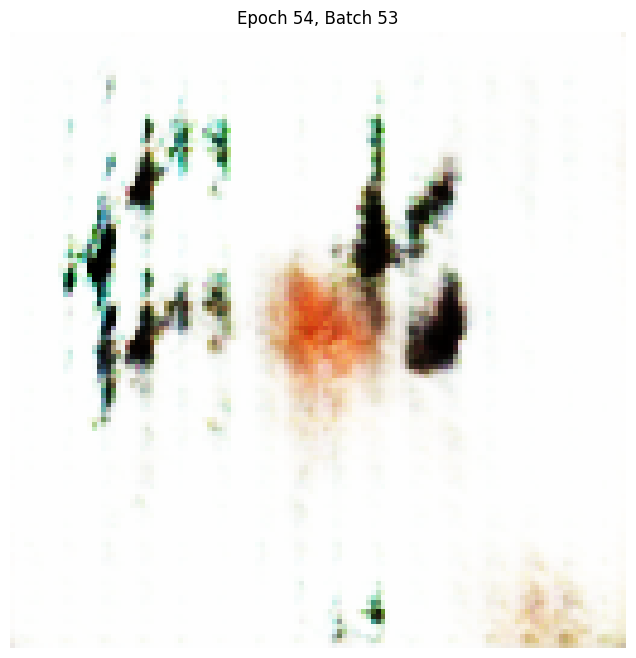

In [31]:
# Training loop
generator.train()
discriminator.train()

for epoch in range(num_epochs): # Do this for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, (real_images, _) in enumerate(dataloader): # Do this for each batch of images
        print(f"Batch {i+1}/{len(dataloader)}")
        real_images = real_images.to(device)  # Move the tensor real_images of dimension batch_size = 64(as defined in the DataLoader)  x 3(RGB images) x 128 x 128 to the device (GPU or CPU)
        batch_size = real_images.size(0)  # # Get batch size retrieves the size of the first dimension of the real_images tensor, which corresponds to the number of images in the current batch

        # Train Discriminator
        optimizer_d.zero_grad()  # Zero discriminator gradients resets the gradients of the discriminator's parameters to zero.
        real_output = discriminator(real_images)  # Pass real images through discriminator to get output
        noise = sample_noise(batch_size, noise_dim)  # Generate noise
        fake_images = generator(noise)  # Generate fake images
        fake_output = discriminator(fake_images.detach())  # Pass fake images through discriminator to get output, detach to prevent gradient tracking
        loss_d = discriminator_loss(real_output, fake_output)  # Calculate discriminator loss
        loss_d.backward()  # Backpropagate discriminator loss
        optimizer_d.step()  # Update discriminator weights
        
        # Train Generator
        optimizer_g.zero_grad()  # Zero generator gradients
        fake_output = discriminator(fake_images)  # Pass fake images through discriminator to get output
        loss_g = generator_loss(fake_output)  # Calculate generator loss
        loss_g.backward()  # Backpropagate generator loss
        optimizer_g.step()  # Update generator weights

        # Save generated images
        with torch.no_grad():
            # Use the first image from fake_images instead of generating new ones
            fake = fake_images[0].unsqueeze(0).cpu()  # Take the first image and add batch dimension
            # Ensure the image is in the range [0, 1]
            fake = (fake + 1) / 2.0  # Transform from [-1, 1] to [0, 1]
            img = torchvision.utils.make_grid(fake, normalize=False)
            img_np = img.detach().permute(1, 2, 0).numpy()  # Add detach() here
            plt.figure(figsize=(8, 8))
            plt.imshow(img_np)
            plt.axis('off')
            plt.title(f"Epoch {epoch+1}, Batch {i+1}")
            
            # Create the directory if it doesn't exist
            import os
            save_dir = r"D:\Users\VICTOR\Desktop\ADRL\Assignment 1\generated_images"
            os.makedirs(save_dir, exist_ok=True)
            
            # Save the image in the specified directory
            save_path = os.path.join(save_dir, f'generated_image_epoch_{epoch+1}_batch_{i+1}.png')
            plt.savefig(save_path)
            plt.close()
